In [4]:
import os
import math
import numpy as np
import pandas as pd
from typing import Iterable, List
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
import torch
from torch import Tensor
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Transformer
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset
from timeit import default_timer as timer
from Constants import *

In [5]:
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True

In [6]:
CONTEXT_LANGUAGE = 'en'
TARGET_LANGUAGE = 'de'

token_transform = {}
vocab_transform = {}

In [7]:
token_transform[CONTEXT_LANGUAGE] = get_tokenizer('spacy', language = 'en_core_web_sm')
token_transform[TARGET_LANGUAGE] = get_tokenizer('spacy', language = 'de_core_news_sm')

In [8]:
data_file.head()

,Go.,Geh.
0,Hi.,Hallo!
1,Hi.,Grüß Gott!
2,Run!,Lauf!
3,Run.,Lauf!
4,Wow!,Potzdonner!


In [9]:
training_set, testing_set = train_test_split(data_file, test_size = 0.25)

In [10]:
print("Number of phrases:",data_file.shape[0])
print("Training subset:",training_set.shape[0])
print("Testing subset:",testing_set.shape[0])

Number of phrases: 267185
Training subset: 200388
Testing subset: 66797


In [11]:
# Custom Dataset_Loader

class Dataset_Loader(Dataset):
    def __init__(self, data):
        self.data = data
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return(
            self.data["Go."].iloc[idx],
            self.data["Geh."].iloc[idx]
        )

In [12]:
train_set = Dataset_Loader(training_set)
validation_set = Dataset_Loader(testing_set)
iterator = iter(train_set)

for _ in range(4):
    sample_phrase = next(iterator)
    print(sample_phrase)


('Tom would still be alive if he had been more careful.', 'Wäre Tom vorsichtiger gewesen, wäre er noch am Leben.')
("You're bleeding again.", 'Du blutest schon wieder.')
('Tom fell flat on his face and broke his glasses.', 'Tom fiel auf die Nase, und die Brille ging ihm dabei zu Bruch.')
('Would you rather be blind or be deaf?', 'Wärst du lieber blind oder taub?')


In [13]:
# Generating tokens

def get_tokens(data_iter: Iterable, language: str) -> List[str]:
    language_index = {CONTEXT_LANGUAGE: 0, TARGET_LANGUAGE: 1}
    
    for text_sample in data_iter:
        yield token_transform[language](text_sample[language_index[language]])
        
# Sentence tokens
UNKNOWN_INDEX, PAD_INDEX, START_INDEX, END_INDEX = 0, 1, 2, 3
standin_symbols = ['<unk>', '<pad>', '<bos>', '<eos>']

for line in [CONTEXT_LANGUAGE, TARGET_LANGUAGE]:
    vocab_transform[line] = build_vocab_from_iterator(get_tokens(train_set, line),
                                                      min_freq = 1,
                                                      specials = standin_symbols,
                                                      special_first = True,)
    
# Unkown_index as default index
for line in [CONTEXT_LANGUAGE, TARGET_LANGUAGE]:
    vocab_transform[line].set_default_index(UNKNOWN_INDEX)

In [14]:
def sequential_transforms(*transforms):
    def func(text_input):
        for transform in transforms:
            text_input = transform(text_input)
        
        return text_input
    return func

def tensor_transform(token_ids: List[int]):
    return torch.cat((torch.tensor([START_INDEX]),
                      torch.tensor(token_ids),
                      torch.tensor([END_INDEX])))


# Convert strings to tensor
text_transform = {}
for line in [CONTEXT_LANGUAGE, TARGET_LANGUAGE]:
    text_transform[line] = sequential_transforms(token_transform[line],
                                                 vocab_transform[line],
                                                 tensor_transform)
    
    
# Getting tokenized context and target batches
def collate_fn(batch):
    context_batch, target_batch = [], []
    for context_sample, target_sample in batch:
        context_batch.append(text_transform[CONTEXT_LANGUAGE](context_sample.rstrip("\n")))
        target_batch.append(text_transform[TARGET_LANGUAGE](target_sample.rstrip("\n")))
        
    context_batch = pad_sequence(context_batch, padding_value = PAD_INDEX, batch_first = True)
    target_batch  = pad_sequence(target_batch,  padding_value = PAD_INDEX, batch_first = True)
    
    return context_batch, target_batch

In [15]:
CONTEXT_VOCAB_SIZE = len(vocab_transform[CONTEXT_LANGUAGE])
TARGET_VOCAB_SIZE = len(vocab_transform[TARGET_LANGUAGE])
DEVICE = ('cuda' if torch.cuda.is_available() else 'cpu')

In [16]:
# Generate masks for context and target snetences

def generate_subsequent_mask(size):
    mask = (torch.triu(torch.ones((size, size), device = DEVICE)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    
    return mask

def generate_mask(context, target):
    context_sequence_len = context.shape[1]
    target_sequence_len  =  target.shape[1]
    
    target_mask = generate_subsequent_mask(target_sequence_len)
    context_mask = torch.zeros((context_sequence_len, context_sequence_len), device = DEVICE).type(torch.bool)
    
    context_padding_mask = (context == PAD_INDEX)
    target_padding_mask = (target == PAD_INDEX)
    
    return context_mask, target_mask, context_padding_mask, target_padding_mask

In [17]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout, max_len = 5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p = dropout)
        
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype = torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        
        return self.dropout(x)

In [18]:
class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size: int, emb_size):
        super(TokenEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.emb_size = emb_size
        
    def forward(self, tokens: Tensor):
        return self.embedding(tokens.long()) * math.sqrt(self.emb_size)

In [19]:
class Seq2SeqTransformer(nn.Module):
    def __init__(self, 
                 num_encoding_layers: int,
                 num_decoding_layers: int,
                 emb_size: int,
                 nhead: int,
                 context_vocab_size: int,
                 target_vocab_size: int,
                 feed_forward_dim: int = 512,
                 dropout: float = 0.1):
        super(Seq2SeqTransformer, self).__init__()
        self.transformer = Transformer(d_model = emb_size,
                                       nhead = nhead,
                                       num_encoder_layers = num_encoding_layers,
                                       num_decoder_layers = num_decoding_layers,
                                       dim_feedforward = feed_forward_dim,
                                       dropout = dropout,
                                       batch_first = True)
        self.generator = nn.Linear(emb_size, target_vocab_size)
        self.context_token_emb = TokenEmbedding(context_vocab_size, emb_size)
        self.target_token_emb = TokenEmbedding(target_vocab_size, emb_size)
        self.positional_encoding = PositionalEncoding(emb_size,
                                                      dropout = dropout)
        
    def forward(self,
                context: Tensor,
                target: Tensor,
                context_mask: Tensor,
                target_mask: Tensor,
                context_padding_mask: Tensor,
                target_padding_mask: Tensor,
                memory_key_padding_mask: Tensor):
        context_emb = self.positional_encoding(self.context_token_emb(context))
        target_emb  = self.positional_encoding(self.target_token_emb(target))
        outs = self.transformer(context_emb,
                                target_emb,
                                context_mask,
                                target_mask,
                                None,
                                context_padding_mask,
                                target_padding_mask,
                                memory_key_padding_mask)
        
        return self.generator(outs)
    
    def encode(self, context: Tensor, context_mask: Tensor):
        return self.transformer.encoder(self.positional_encoding(self.context_token_emb(context)), context_mask)
    
    def decode(self, target: Tensor, memory: Tensor, target_mask: Tensor):
        return self.transformer.decoder(self.positional_encoding(self.target_token_emb(target)), memory, target_mask)

In [17]:
model = Seq2SeqTransformer(NUM_ENCODING_LAYERS,
                           NUM_ENCODING_LAYERS,
                           EMBEDDING_SIZE,
                           NUM_MULTIHEAD,
                           CONTEXT_VOCAB_SIZE,
                           TARGET_VOCAB_SIZE,
                           FEED_FWD_DIMENSION).to(DEVICE)

total_params = sum(p.numel() for p in model.parameters())
print(f"{total_params:,} parameters.")
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} trainable parameters.")
print(model)

19,426,146 parameters.
19,426,146 trainable parameters.
Seq2SeqTransformer(
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-2): 3 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=192, out_features=192, bias=True)
          )
          (linear1): Linear(in_features=192, out_features=192, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=192, out_features=192, bias=True)
          (norm1): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
      )
      (norm): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
    )
    (decoder): TransformerDecoder(
      (layers): ModuleList(
        (0-2): 3 x Transfo

In [18]:
loss_fn = torch.nn.CrossEntropyLoss(ignore_index = PAD_INDEX)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001, betas = (0.9, 0.98), eps = 1e-9)

In [20]:
train_dataloader = DataLoader(train_set, batch_size = BATCH_SIZE, collate_fn = collate_fn)
def train_epoch(model, optimizer):
    print("Training")
    model.train()
    losses = 0
    
    for context, target in tqdm(train_dataloader, total = len(list(train_dataloader))):
        context = context.to(DEVICE)
        target = target.to(DEVICE)
        
        target_input = target[:, :-1]
        
        context_mask, target_mask, context_padding_mask, target_padding_mask = generate_mask(context, target_input)
        
        logits = model(context,
                       target_input,
                       context_mask,
                       target_mask,
                       context_padding_mask,
                       target_padding_mask,
                       context_padding_mask)
        
        optimizer.zero_grad()
        
        target_out = target[:, 1:]
        loss = loss_fn(logits.view(-1, TARGET_VOCAB_SIZE), target_out.contiguous().view(-1))
        loss.backward()
        
        optimizer.step()
        losses += loss.item()
        
    return losses / len(list(train_dataloader))

val_dataloader = DataLoader(validation_set, batch_size = BATCH_SIZE, collate_fn = collate_fn)
def evaluate(model):
    print("Validating")
    model.eval()
    losses = 0
    
    for context, target in tqdm(val_dataloader, total = len(list(val_dataloader))):
        context = context.to(DEVICE)
        target = target.to(DEVICE)
        
        target_input = target[:, :-1]
        
        context_mask, target_mask, context_padding_mask, target_padding_mask = generate_mask(context, target_input)
        
        logits = model(context,
                       target_input,
                       context_mask,
                       target_mask,
                       context_padding_mask,
                       target_padding_mask,
                       context_padding_mask)
        
        target_out = target[:, 1:]
        loss = loss_fn(logits.view(-1, TARGET_VOCAB_SIZE), target_out.contiguous().view(-1))
        losses += loss.item()
        
    return losses / len(list(val_dataloader))

In [20]:
%%time

train_loss_list, validation_loss_list = [], []
for epoch in range(1, EPOCHS + 1):
    start_time = timer()
    train_loss = train_epoch(model, optimizer)
    validation_loss = evaluate(model)
    end_time = timer()
    train_loss_list.append(train_loss)
    validation_loss_list.append(validation_loss)
    print(f"Epoch: {epoch}")
    print(f"Training loss: {train_loss:.3f}")
    print(f"Validation loss: {validation_loss:.3f}")
    print(f"Epoch time = {(end_time - start_time):.3f}s\n")
    print("~ " * 100)

Training


  0%|          | 0/1044 [00:00<?, ?it/s]

c:\Users\dell\miniconda3\envs\tf_cpu\Lib\site-packages\torch\nn\functional.py:5076: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Validating


  0%|          | 0/348 [00:00<?, ?it/s]

Epoch: 1
Training loss: 5.330
Validation loss: 4.266
Epoch time = 7777.862s

~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ 
Training


  0%|          | 0/1044 [00:00<?, ?it/s]

Validating


  0%|          | 0/348 [00:00<?, ?it/s]

Epoch: 2
Training loss: 4.085
Validation loss: 3.731
Epoch time = 8114.984s

~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ 
Training


  0%|          | 0/1044 [00:00<?, ?it/s]

Validating


  0%|          | 0/348 [00:00<?, ?it/s]

Epoch: 3
Training loss: 3.674
Validation loss: 3.396
Epoch time = 8122.337s

~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ 
Training


  0%|          | 0/1044 [00:00<?, ?it/s]

Validating


  0%|          | 0/348 [00:00<?, ?it/s]

Epoch: 4
Training loss: 3.391
Validation loss: 3.153
Epoch time = 7871.462s

~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ 
Training


  0%|          | 0/1044 [00:00<?, ?it/s]

Validating


  0%|          | 0/348 [00:00<?, ?it/s]

Epoch: 5
Training loss: 3.172
Validation loss: 2.957
Epoch time = 8867.572s

~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ 
Training


  0%|          | 0/1044 [00:00<?, ?it/s]

Validating


  0%|          | 0/348 [00:00<?, ?it/s]

Epoch: 6
Training loss: 2.995
Validation loss: 2.798
Epoch time = 7865.548s

~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ 
Training


  0%|          | 0/1044 [00:00<?, ?it/s]

Validating


  0%|          | 0/348 [00:00<?, ?it/s]

Epoch: 7
Training loss: 2.845
Validation loss: 2.663
Epoch time = 7808.896s

~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ 
Training


  0%|          | 0/1044 [00:00<?, ?it/s]

Validating


  0%|          | 0/348 [00:00<?, ?it/s]

Epoch: 8
Training loss: 2.714
Validation loss: 2.547
Epoch time = 7873.310s

~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ 
Training


  0%|          | 0/1044 [00:00<?, ?it/s]

Validating


  0%|          | 0/348 [00:00<?, ?it/s]

Epoch: 9
Training loss: 2.601
Validation loss: 2.453
Epoch time = 7987.202s

~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ 
Training


  0%|          | 0/1044 [00:00<?, ?it/s]

Validating


  0%|          | 0/348 [00:00<?, ?it/s]

Epoch: 10
Training loss: 2.502
Validation loss: 2.369
Epoch time = 7762.525s

~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ 
Training


  0%|          | 0/1044 [00:00<?, ?it/s]

Validating


  0%|          | 0/348 [00:00<?, ?it/s]

Epoch: 11
Training loss: 2.414
Validation loss: 2.297
Epoch time = 7787.308s

~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ 
Training


  0%|          | 0/1044 [00:00<?, ?it/s]

Validating


  0%|          | 0/348 [00:00<?, ?it/s]

Epoch: 12
Training loss: 2.338
Validation loss: 2.236
Epoch time = 7742.731s

~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ 
Training


  0%|          | 0/1044 [00:00<?, ?it/s]

Validating


  0%|          | 0/348 [00:00<?, ?it/s]

Epoch: 13
Training loss: 2.270
Validation loss: 2.183
Epoch time = 7758.354s

~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ 
Training


  0%|          | 0/1044 [00:00<?, ?it/s]

Validating


  0%|          | 0/348 [00:00<?, ?it/s]

Epoch: 14
Training loss: 2.207
Validation loss: 2.135
Epoch time = 7755.812s

~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ 
Training


  0%|          | 0/1044 [00:00<?, ?it/s]

Validating


  0%|          | 0/348 [00:00<?, ?it/s]

Epoch: 15
Training loss: 2.154
Validation loss: 2.095
Epoch time = 33074.199s

~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ 
Training


  0%|          | 0/1044 [00:00<?, ?it/s]

Validating


  0%|          | 0/348 [00:00<?, ?it/s]

Epoch: 16
Training loss: 2.102
Validation loss: 2.052
Epoch time = 7814.023s

~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ 
Training


  0%|          | 0/1044 [00:00<?, ?it/s]

Validating


  0%|          | 0/348 [00:00<?, ?it/s]

Epoch: 17
Training loss: 2.056
Validation loss: 2.020
Epoch time = 7784.789s

~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ 
Training


  0%|          | 0/1044 [00:00<?, ?it/s]

Validating


  0%|          | 0/348 [00:00<?, ?it/s]

Epoch: 18
Training loss: 2.015
Validation loss: 1.990
Epoch time = 7838.079s

~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ 
Training


  0%|          | 0/1044 [00:00<?, ?it/s]

Validating


  0%|          | 0/348 [00:00<?, ?it/s]

Epoch: 19
Training loss: 1.976
Validation loss: 1.959
Epoch time = 7769.610s

~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ 
Training


  0%|          | 0/1044 [00:00<?, ?it/s]

Validating


  0%|          | 0/348 [00:00<?, ?it/s]

Epoch: 20
Training loss: 1.940
Validation loss: 1.937
Epoch time = 7761.897s

~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ 
Training


  0%|          | 0/1044 [00:00<?, ?it/s]

Validating


  0%|          | 0/348 [00:00<?, ?it/s]

Epoch: 21
Training loss: 1.907
Validation loss: 1.911
Epoch time = 7721.800s

~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ 
Training


  0%|          | 0/1044 [00:00<?, ?it/s]

Validating


  0%|          | 0/348 [00:00<?, ?it/s]

Epoch: 22
Training loss: 1.875
Validation loss: 1.892
Epoch time = 7768.224s

~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ 
Training


  0%|          | 0/1044 [00:00<?, ?it/s]

Validating


  0%|          | 0/348 [00:00<?, ?it/s]

Epoch: 23
Training loss: 1.848
Validation loss: 1.870
Epoch time = 7769.616s

~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ 
Training


  0%|          | 0/1044 [00:00<?, ?it/s]

Validating


  0%|          | 0/348 [00:00<?, ?it/s]

Epoch: 24
Training loss: 1.820
Validation loss: 1.853
Epoch time = 7780.591s

~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ 
Training


  0%|          | 0/1044 [00:00<?, ?it/s]

Validating


  0%|          | 0/348 [00:00<?, ?it/s]

Epoch: 25
Training loss: 1.797
Validation loss: 1.833
Epoch time = 7801.290s

~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ 
Training


  0%|          | 0/1044 [00:00<?, ?it/s]

Validating


  0%|          | 0/348 [00:00<?, ?it/s]

Epoch: 26
Training loss: 1.773
Validation loss: 1.820
Epoch time = 9368.529s

~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ 
Training


  0%|          | 0/1044 [00:00<?, ?it/s]

Validating


  0%|          | 0/348 [00:00<?, ?it/s]

Epoch: 27
Training loss: 1.750
Validation loss: 1.803
Epoch time = 8083.321s

~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ 
Training


  0%|          | 0/1044 [00:00<?, ?it/s]

Validating


  0%|          | 0/348 [00:00<?, ?it/s]

Epoch: 28
Training loss: 1.729
Validation loss: 1.789
Epoch time = 7856.260s

~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ 
Training


  0%|          | 0/1044 [00:00<?, ?it/s]

Validating


  0%|          | 0/348 [00:00<?, ?it/s]

Epoch: 29
Training loss: 1.712
Validation loss: 1.778
Epoch time = 7839.484s

~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ 
Training


  0%|          | 0/1044 [00:00<?, ?it/s]

Validating


  0%|          | 0/348 [00:00<?, ?it/s]

Epoch: 30
Training loss: 1.694
Validation loss: 1.765
Epoch time = 7869.546s

~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ 
CPU times: total: 5d 3h 43min 2s
Wall time: 3d 1h 2min 49s


In [22]:
def save_plots(train_loss, validation_loss):
    plt.figure(figsize = (10, 8))
    plt.plot(train_loss, label = 'Train loss')
    plt.plot(validation_loss, label = 'Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig(os.path.join("../outputs", "deu_loss.png"))
    plt.show()

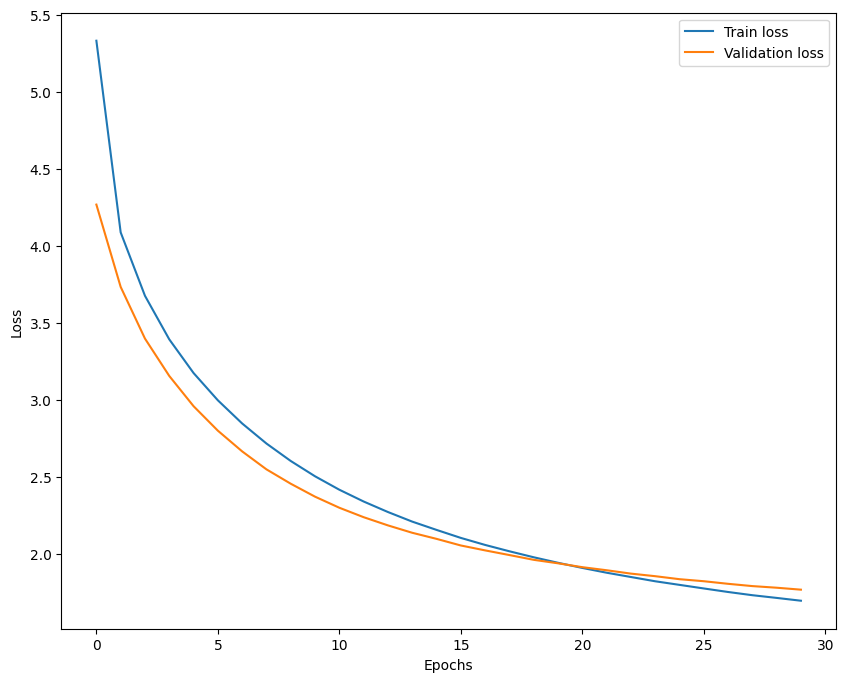

In [23]:
save_plots(train_loss_list, validation_loss_list)

In [24]:
torch.save(model, "../outputs/deu_model.pth")

In [23]:
model = torch.load('../outputs/deu_model.pth')

In [24]:

def greedy_decode(model, context, context_mask, max_len, start_symbol):
    context = context.to(DEVICE)
    context_mask = context_mask.to(DEVICE)
    memory = model.encode(context, context_mask)
    y_pred = torch.ones(1, 1).fill_(start_symbol).type(torch.long).to(DEVICE)
    for i in range(max_len - 1):
        memory = memory.to(DEVICE)
        if i == 0:
            y_pred = y_pred.transpose(1, 0)
        target_mask = (generate_subsequent_mask(y_pred.size(1))
                       .type(torch.bool)).to(DEVICE)
        out = model.decode(y_pred, memory, target_mask)
        out = out
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim = 1)
        next_word = next_word.item()
        y_pred = torch.cat([y_pred, torch.ones(1, 1).type_as(context.data).fill_(next_word)], dim = 1)
        if next_word == END_INDEX:
            break
        
    return y_pred

def translate(model: torch.nn.Module, context_sentence: str):
    model.eval()
    context = text_transform[CONTEXT_LANGUAGE](context_sentence).view(1, -1)
    num_tokens = context.shape[1]
    context_mask = (torch.zeros(num_tokens, num_tokens)).type(torch.bool)
    target_tokens = greedy_decode(model,
                                  context,
                                  context_mask,
                                  max_len = num_tokens + 5, 
                                  start_symbol = START_INDEX).flatten()

    return " ".join(vocab_transform[TARGET_LANGUAGE].lookup_tokens(list(target_tokens.cpu().numpy()))).replace("<bos>", "").replace("<eos>", "")

In [25]:
sample_sentences = [
    ["It's bright outside today!", "Es ist heute drauben hell!"],
    ["Don't forget to dehydrate.", "Vergiss nicht zu dehydrieren"],
    ["I'll see you again tomorrow.", "Wir sehen uns morgen wieder"],
    ["What time is it?", "Um wie viel Uhr ist es?"],
    ["This translation model is not bad.", "Dieses Uberstezungsmodell ist nicht schlecht"],
    ["Happy holidays to all who celebrate.", "Frohe Feiertage an alle, die feiern"]
]
for sentence in sample_sentences:
    print(f"Context: {sentence[0]}")
    print(f"Actual: {sentence[1]}")
    print(f"Predicted: {translate(model, sentence[0])}\n")

Context: It's bright outside today!
Actual: Es ist heute drauben hell!
Predicted:  Draußen ist es heute ! 

Context: Don't forget to dehydrate.
Actual: Vergiss nicht zu dehydrieren
Predicted:  Vergiss nicht , mich zu versteckt . 

Context: I'll see you again tomorrow.
Actual: Wir sehen uns morgen wieder
Predicted:  Ich werde dich morgen wiedersehen . 

Context: What time is it?
Actual: Um wie viel Uhr ist es?
Predicted:  Um wie viel Uhr ist es ? 

Context: This translation model is not bad.
Actual: Dieses Uberstezungsmodell ist nicht schlecht
Predicted:  Diese Übersetzung ist nicht schlecht . 

Context: Happy holidays to all who celebrate.
Actual: Frohe Feiertage an alle, die feiern
Predicted:  Wer alle gerne über den Kopf . 

